# Surface Temperature Proxy (Visual Estimation)

**Obiettivo**: Generare una mappa di temperatura superficiale proxy basata su caratteristiche visive RGB.

**Nota importante**: Le immagini sono RGB (3 canali) senza bande termiche/infrarosse. Non possiamo misurare la vera temperatura superficiale, ma possiamo creare un **proxy visivo** basato su correlazioni colore-temperatura.

**Assunzioni**:
- Aree calde (deserto): toni rossi/gialli, alta luminosità
- Aree fredde (acqua): toni blu, bassa luminosità
- Vegetazione: intermedia
- Nuvole: fredde, alta luminosità

**Approccio**:
1. Indice di warmth combinato (red ratio + R-B difference + brightness)
2. Normalizzazione e scaling a range temperatura plausibile
3. Heatmap con colormap cool-to-warm
4. Overlay su immagine originale
5. Confronto tra categorie (deserto=caldo, acqua=freddo)

## 1. Imports

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
import cv2
from pathlib import Path
import random
from typing import Tuple, List

# Set random seed
random.seed(42)
np.random.seed(42)

# Configure matplotlib
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['figure.dpi'] = 100

%matplotlib inline

print("Imports completed successfully")

Imports completed successfully


## 2. Configuration

In [2]:
# Paths
DATA_DIR = Path('../data')
CATEGORIES = ['cloudy', 'desert', 'green_area', 'water']
TARGET_SIZE = (64, 64)

# Temperature proxy parameters
# These are arbitrary scales for visualization (not real temperatures)
TEMP_MIN = 10  # °C (coldest - water, shadows)
TEMP_MAX = 40  # °C (hottest - desert, bright areas)

# Weights for temperature proxy calculation
WEIGHTS = {
    'red_ratio': 0.4,      # R/(R+G+B) - warm colors
    'rb_diff': 0.3,        # R-B - warmth vs coolness
    'brightness': 0.3,     # Overall brightness
}

# Overlay transparency
OVERLAY_ALPHA = 0.5

print(f"Data directory: {DATA_DIR.absolute()}")
print(f"Temperature range: {TEMP_MIN}°C - {TEMP_MAX}°C (proxy scale)")
print(f"Weights: {WEIGHTS}")

Data directory: /Users/aldojacopo/forme-idee/notebooks/../data
Temperature range: 10°C - 40°C (proxy scale)
Weights: {'red_ratio': 0.4, 'rb_diff': 0.3, 'brightness': 0.3}


## 3. Utility Functions

In [3]:
def load_and_resize_image(img_path: Path, target_size: Tuple[int, int] = TARGET_SIZE) -> np.ndarray:
    """
    Load an image and resize it to target size.
    
    Args:
        img_path: Path to image file
        target_size: (width, height) tuple
    
    Returns:
        numpy array (H, W, 3) in RGB format
    """
    img = Image.open(img_path).convert('RGB')
    img_resized = img.resize(target_size, Image.LANCZOS)
    return np.array(img_resized)


def load_sample_images(category: str, n_samples: int = 10) -> List[np.ndarray]:
    """
    Load random sample images from a category.
    """
    category_path = DATA_DIR / category
    image_files = list(category_path.glob('*.jpg'))
    sampled_files = random.sample(image_files, min(n_samples, len(image_files)))
    return [load_and_resize_image(f) for f in sampled_files]


print("Utility functions defined")

Utility functions defined


## 4. Temperature Proxy Calculation

In [4]:
def calculate_temperature_proxy(img_rgb: np.ndarray,
                               weights: dict = WEIGHTS,
                               temp_min: float = TEMP_MIN,
                               temp_max: float = TEMP_MAX) -> np.ndarray:
    """
    Calculate a temperature proxy based on RGB color features.
    
    The proxy combines:
    1. Red ratio R/(R+G+B) - higher for warm colors
    2. R-B difference - positive for warm, negative for cool
    3. Brightness - overall illumination
    
    Args:
        img_rgb: RGB image (H, W, 3)
        weights: Dictionary with weights for each component
        temp_min: Minimum temperature in proxy scale (°C)
        temp_max: Maximum temperature in proxy scale (°C)
    
    Returns:
        Temperature proxy map (H, W) in °C
    """
    img_float = img_rgb.astype(np.float32)
    r = img_float[:, :, 0]
    g = img_float[:, :, 1]
    b = img_float[:, :, 2]
    
    # 1. Red ratio (0-1 range)
    total = r + g + b + 1e-6
    red_ratio = r / total
    
    # 2. R-B difference (normalize to 0-1)
    rb_diff = r - b
    rb_diff_norm = (rb_diff - rb_diff.min()) / (rb_diff.max() - rb_diff.min() + 1e-6)
    
    # 3. Brightness (normalize to 0-1)
    brightness = np.mean(img_float, axis=2)
    brightness_norm = brightness / 255.0
    
    # Weighted combination
    temp_index = (weights['red_ratio'] * red_ratio + 
                  weights['rb_diff'] * rb_diff_norm + 
                  weights['brightness'] * brightness_norm)
    
    # Scale to temperature range
    temp_proxy = temp_min + temp_index * (temp_max - temp_min)
    
    return temp_proxy


def calculate_simple_brightness_temp(img_rgb: np.ndarray,
                                    temp_min: float = TEMP_MIN,
                                    temp_max: float = TEMP_MAX) -> np.ndarray:
    """
    Simple temperature proxy based only on brightness.
    (For comparison with the full model)
    
    Args:
        img_rgb: RGB image (H, W, 3)
        temp_min: Minimum temperature
        temp_max: Maximum temperature
    
    Returns:
        Temperature proxy map (H, W)
    """
    brightness = np.mean(img_rgb.astype(np.float32), axis=2)
    brightness_norm = brightness / 255.0
    temp_proxy = temp_min + brightness_norm * (temp_max - temp_min)
    return temp_proxy


print("Temperature proxy functions defined")

Temperature proxy functions defined


## 5. Visualization Functions

In [5]:
def create_custom_temp_colormap():
    """
    Create a custom colormap for temperature visualization.
    Cool (blue) -> Neutral (green/yellow) -> Warm (red)
    """
    colors = [
        (0.0, 0.0, 0.5),  # Dark blue (cold)
        (0.0, 0.5, 1.0),  # Light blue
        (0.0, 1.0, 1.0),  # Cyan
        (0.0, 1.0, 0.0),  # Green
        (1.0, 1.0, 0.0),  # Yellow
        (1.0, 0.5, 0.0),  # Orange
        (1.0, 0.0, 0.0),  # Red (hot)
    ]
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list('temperature', colors, N=n_bins)
    return cmap


def visualize_temperature_map(img_rgb: np.ndarray,
                             temp_map: np.ndarray,
                             title: str = "Temperature Proxy") -> None:
    """
    Visualize original image, temperature map, and overlay.
    
    Args:
        img_rgb: Original RGB image
        temp_map: Temperature proxy map
        title: Plot title
    """
    cmap = create_custom_temp_colormap()
    
    # Create overlay
    overlay = create_temp_overlay(img_rgb, temp_map, alpha=OVERLAY_ALPHA)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original
    axes[0].imshow(img_rgb)
    axes[0].set_title('Original', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Temperature map
    im = axes[1].imshow(temp_map, cmap=cmap, vmin=TEMP_MIN, vmax=TEMP_MAX)
    axes[1].set_title('Temperature Proxy Map', fontsize=12, fontweight='bold')
    axes[1].axis('off')
    cbar = plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    cbar.set_label('Temperature (°C)', rotation=270, labelpad=15)
    
    # Overlay
    axes[2].imshow(overlay)
    axes[2].set_title('Overlay (Heatmap)', fontsize=12, fontweight='bold')
    axes[2].axis('off')
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


def create_temp_overlay(img_rgb: np.ndarray,
                       temp_map: np.ndarray,
                       alpha: float = OVERLAY_ALPHA) -> np.ndarray:
    """
    Create a semi-transparent overlay of temperature heatmap on original image.
    
    Args:
        img_rgb: Original RGB image
        temp_map: Temperature proxy map
        alpha: Transparency of heatmap
    
    Returns:
        Blended image
    """
    cmap = create_custom_temp_colormap()
    
    # Normalize temperature map to 0-1
    temp_norm = (temp_map - TEMP_MIN) / (TEMP_MAX - TEMP_MIN)
    temp_norm = np.clip(temp_norm, 0, 1)
    
    # Apply colormap (returns RGBA)
    temp_colored = cmap(temp_norm)
    
    # Convert to RGB (0-255)
    temp_rgb = (temp_colored[:, :, :3] * 255).astype(np.uint8)
    
    # Blend with original
    blended = (alpha * temp_rgb + (1 - alpha) * img_rgb).astype(np.uint8)
    
    return blended


def visualize_comparison(img_rgb: np.ndarray) -> None:
    """
    Compare different temperature proxy methods.
    """
    temp_full = calculate_temperature_proxy(img_rgb)
    temp_brightness = calculate_simple_brightness_temp(img_rgb)
    
    cmap = create_custom_temp_colormap()
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original
    axes[0].imshow(img_rgb)
    axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Brightness-only proxy
    im1 = axes[1].imshow(temp_brightness, cmap=cmap, vmin=TEMP_MIN, vmax=TEMP_MAX)
    axes[1].set_title('Brightness-Only Proxy', fontsize=12, fontweight='bold')
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    
    # Full proxy (warmth + brightness)
    im2 = axes[2].imshow(temp_full, cmap=cmap, vmin=TEMP_MIN, vmax=TEMP_MAX)
    axes[2].set_title('Full Proxy (Warmth + Brightness)', fontsize=12, fontweight='bold')
    axes[2].axis('off')
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)
    
    plt.suptitle('Temperature Proxy Methods Comparison', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


print("Visualization functions defined")

Visualization functions defined


## 6. Test on Sample Images

### 6.1 Test on Desert (Expected: Hot)

Loaded 3 desert images

Testing on desert image (expected: HOT temperatures)



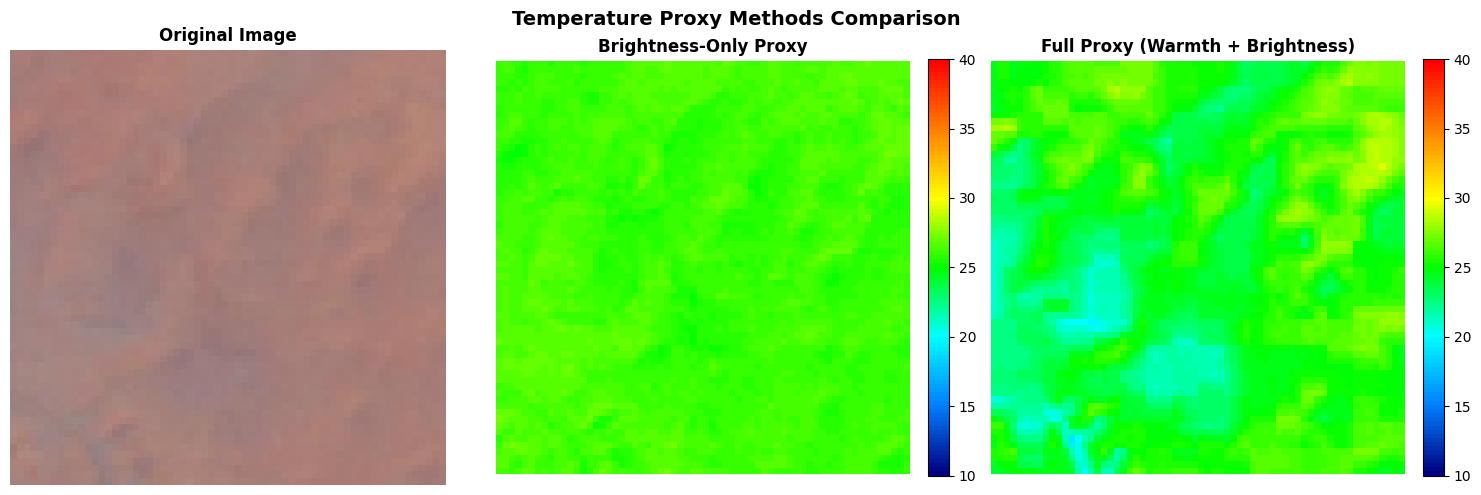

In [6]:
# Load desert samples
desert_samples = load_sample_images('desert', n_samples=3)
print(f"Loaded {len(desert_samples)} desert images")

# Test on first desert image
test_img = desert_samples[0]
print(f"\nTesting on desert image (expected: HOT temperatures)\n")

# Compare methods
visualize_comparison(test_img)

Temperature proxy for desert images:


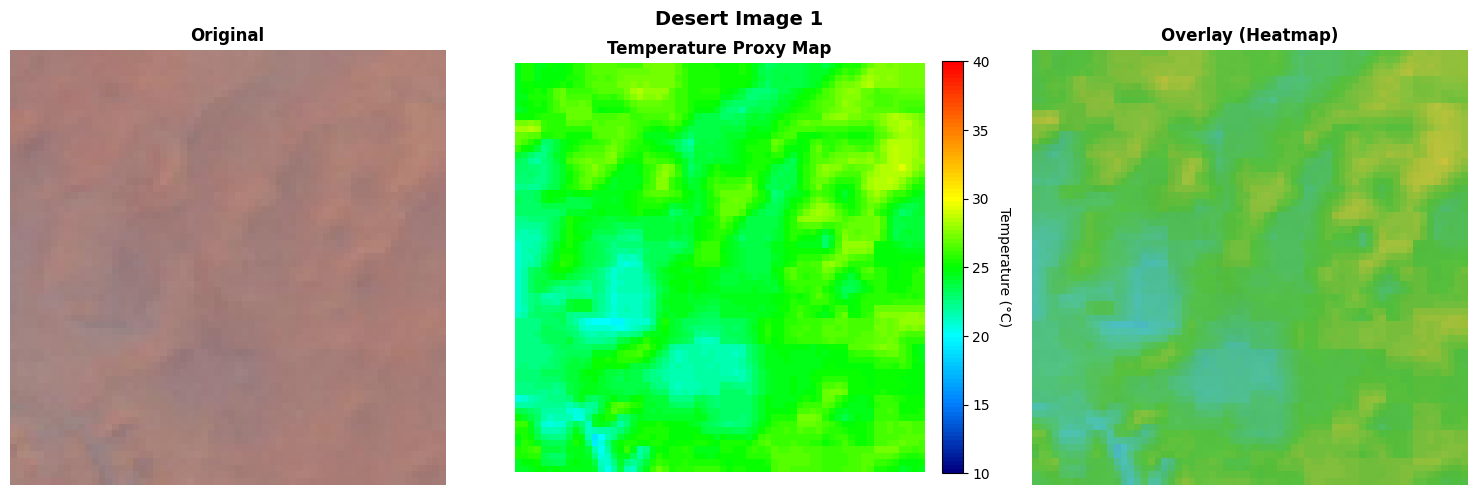

Desert 1: Mean temp = 24.8°C, Max = 29.2°C, Min = 19.2°C


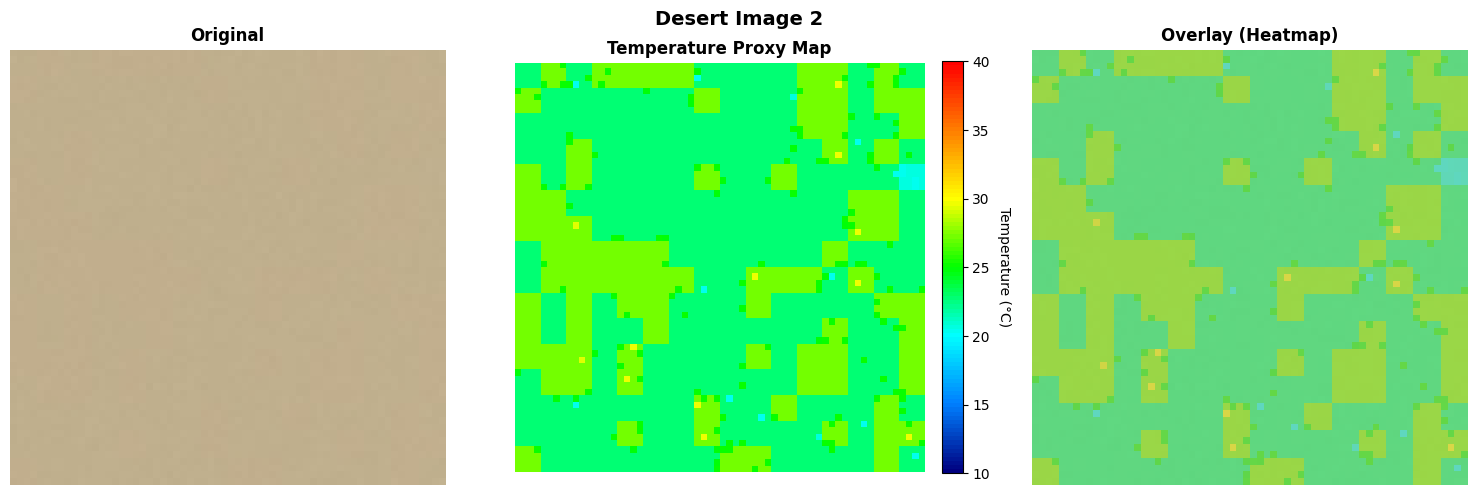

Desert 2: Mean temp = 24.3°C, Max = 29.6°C, Min = 20.5°C


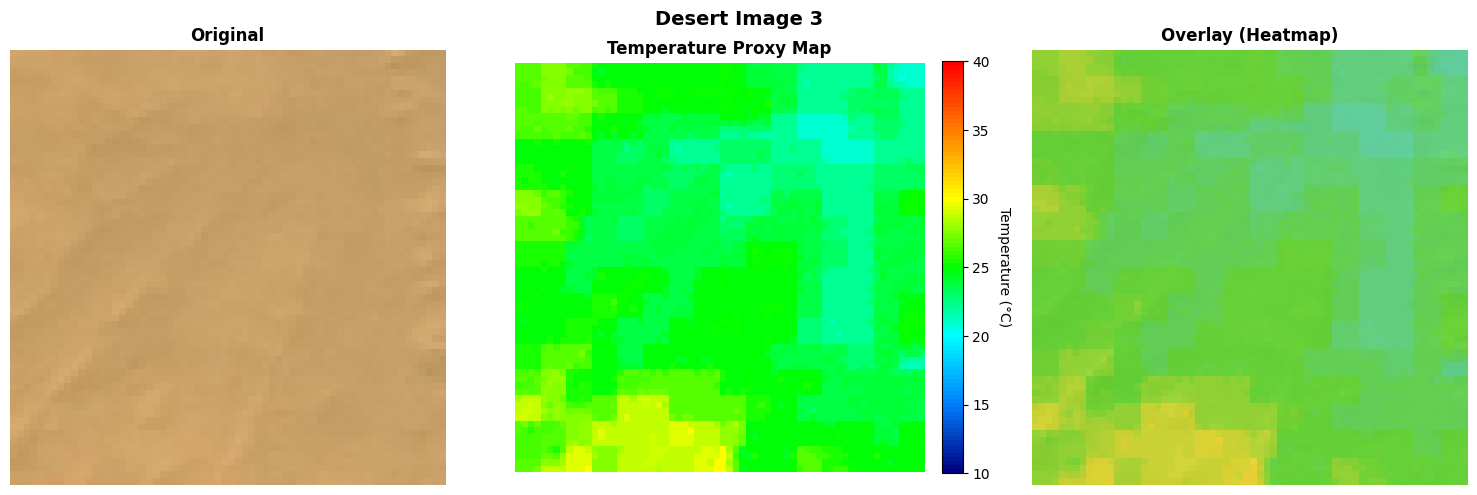

Desert 3: Mean temp = 24.6°C, Max = 30.0°C, Min = 20.4°C


In [7]:
# Test on multiple desert images
print("Temperature proxy for desert images:")
for i, img in enumerate(desert_samples):
    temp_map = calculate_temperature_proxy(img)
    visualize_temperature_map(img, temp_map, title=f"Desert Image {i+1}")
    print(f"Desert {i+1}: Mean temp = {np.mean(temp_map):.1f}°C, "
          f"Max = {np.max(temp_map):.1f}°C, Min = {np.min(temp_map):.1f}°C")

### 6.2 Test on Water (Expected: Cold)

Loaded 3 water images

Testing on water images (expected: COLD temperatures)



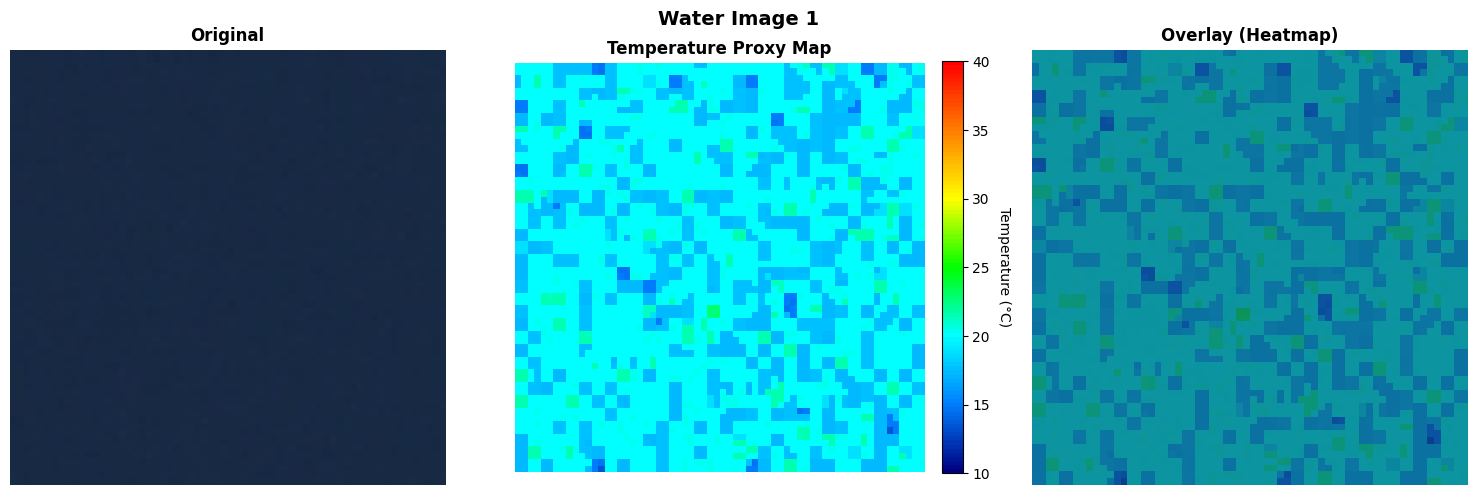

Water 1: Mean temp = 19.3°C, Max = 22.8°C, Min = 13.5°C


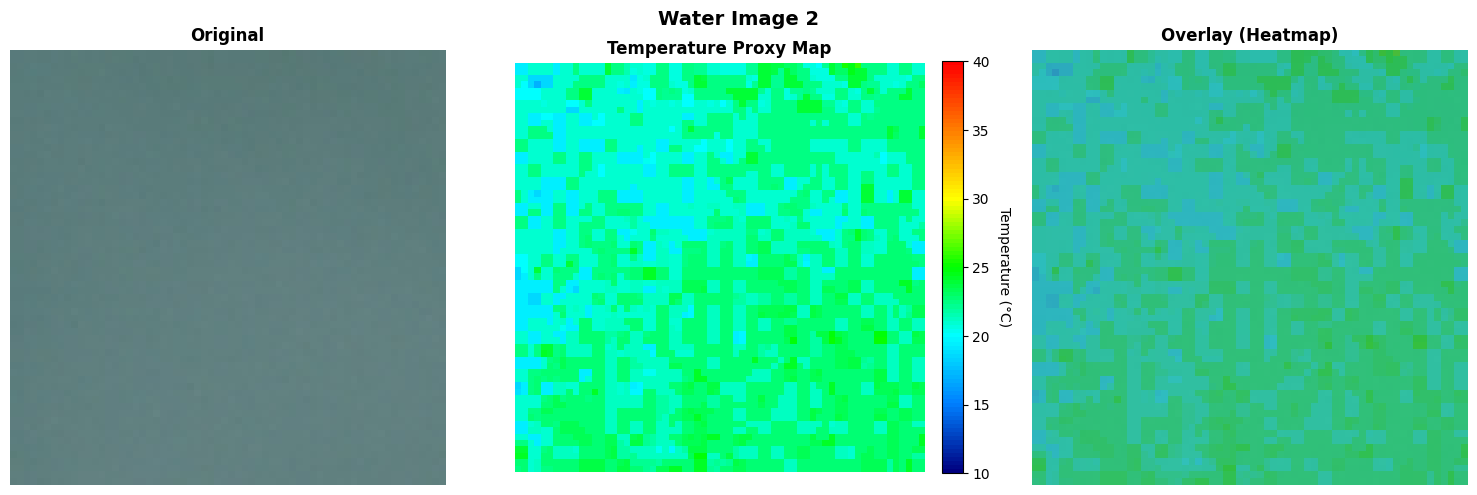

Water 2: Mean temp = 21.8°C, Max = 26.1°C, Min = 17.0°C


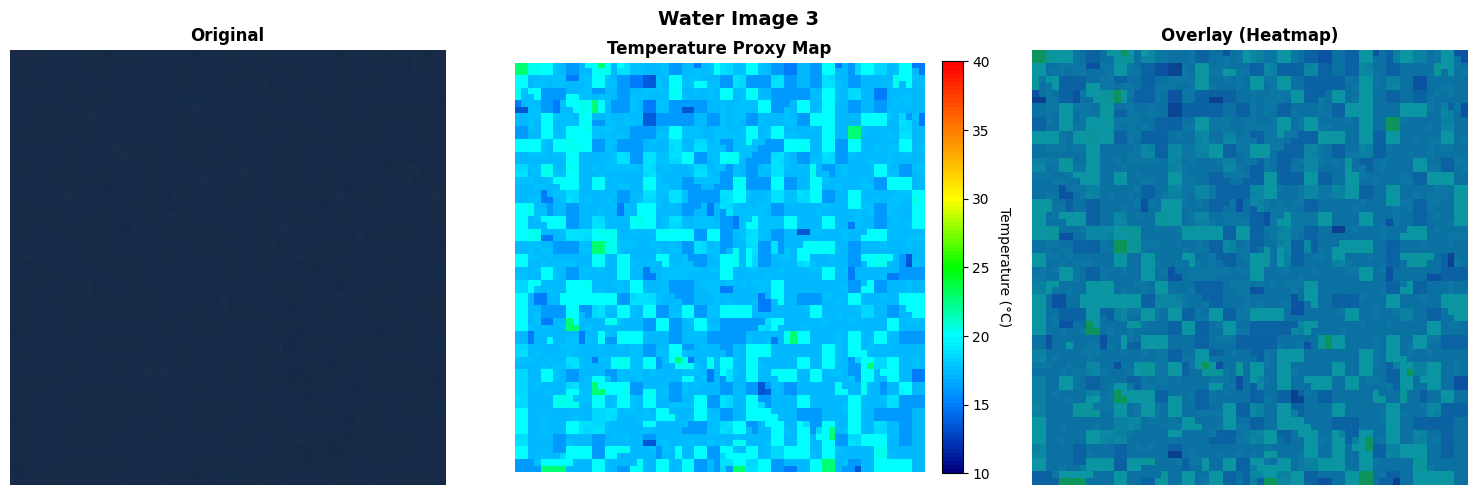

Water 3: Mean temp = 17.9°C, Max = 22.9°C, Min = 13.4°C


In [8]:
# Load water samples
water_samples = load_sample_images('water', n_samples=3)
print(f"Loaded {len(water_samples)} water images")
print("\nTesting on water images (expected: COLD temperatures)\n")

for i, img in enumerate(water_samples):
    temp_map = calculate_temperature_proxy(img)
    visualize_temperature_map(img, temp_map, title=f"Water Image {i+1}")
    print(f"Water {i+1}: Mean temp = {np.mean(temp_map):.1f}°C, "
          f"Max = {np.max(temp_map):.1f}°C, Min = {np.min(temp_map):.1f}°C")

### 6.3 Test on Vegetation (Expected: Intermediate)

Loaded 3 vegetation images

Testing on vegetation images (expected: INTERMEDIATE temperatures)



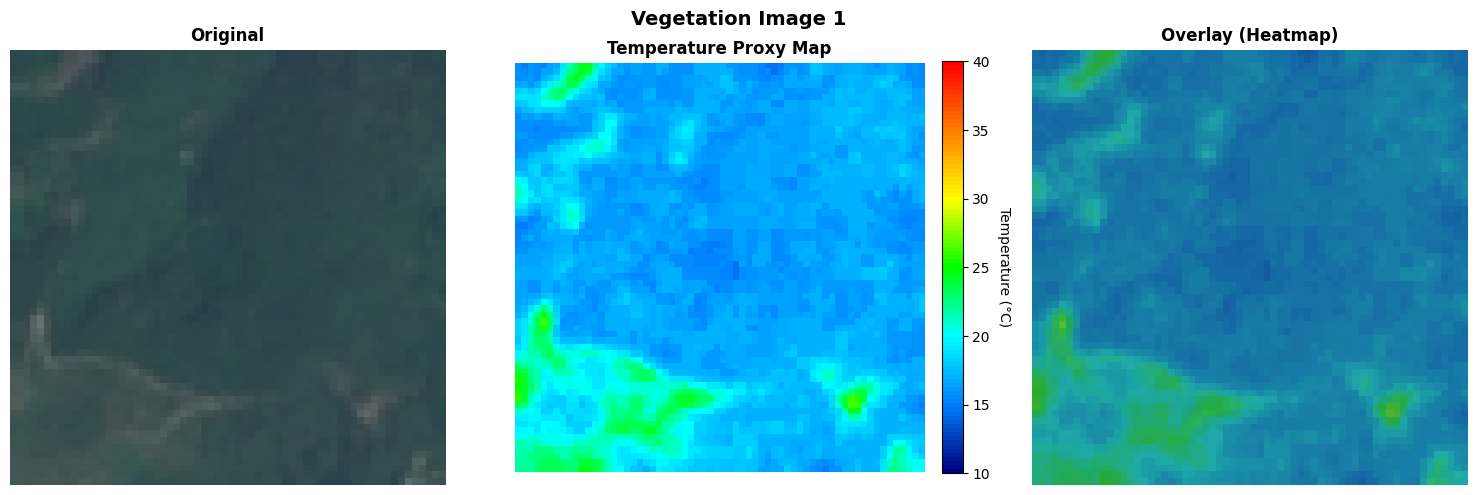

Vegetation 1: Mean temp = 17.5°C, Max = 26.4°C, Min = 14.7°C


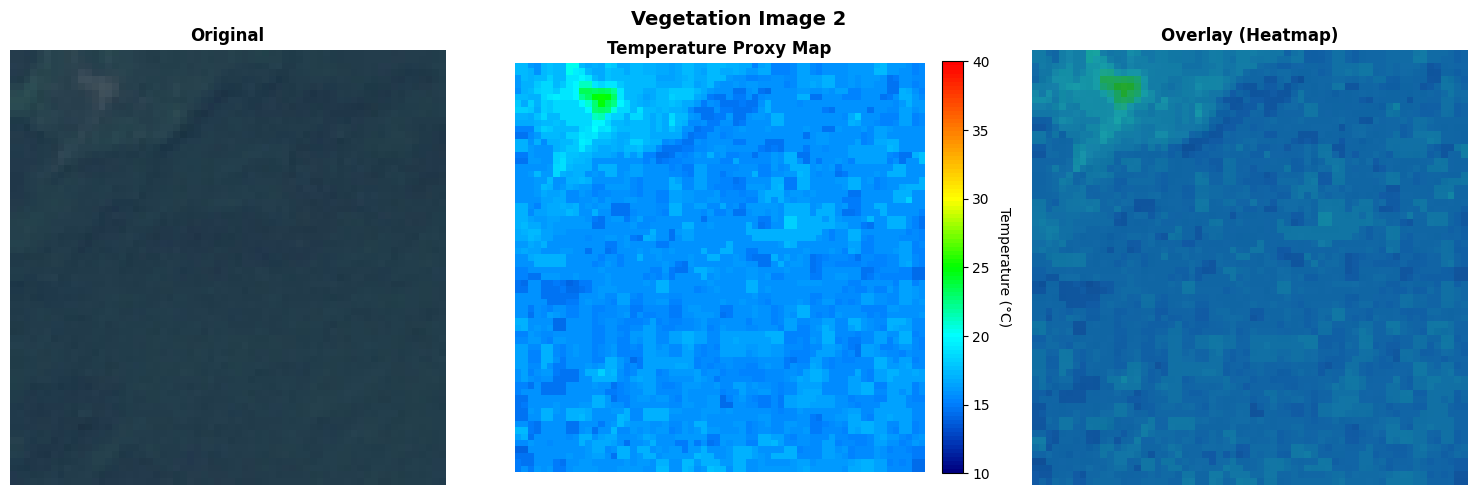

Vegetation 2: Mean temp = 16.1°C, Max = 25.1°C, Min = 14.2°C


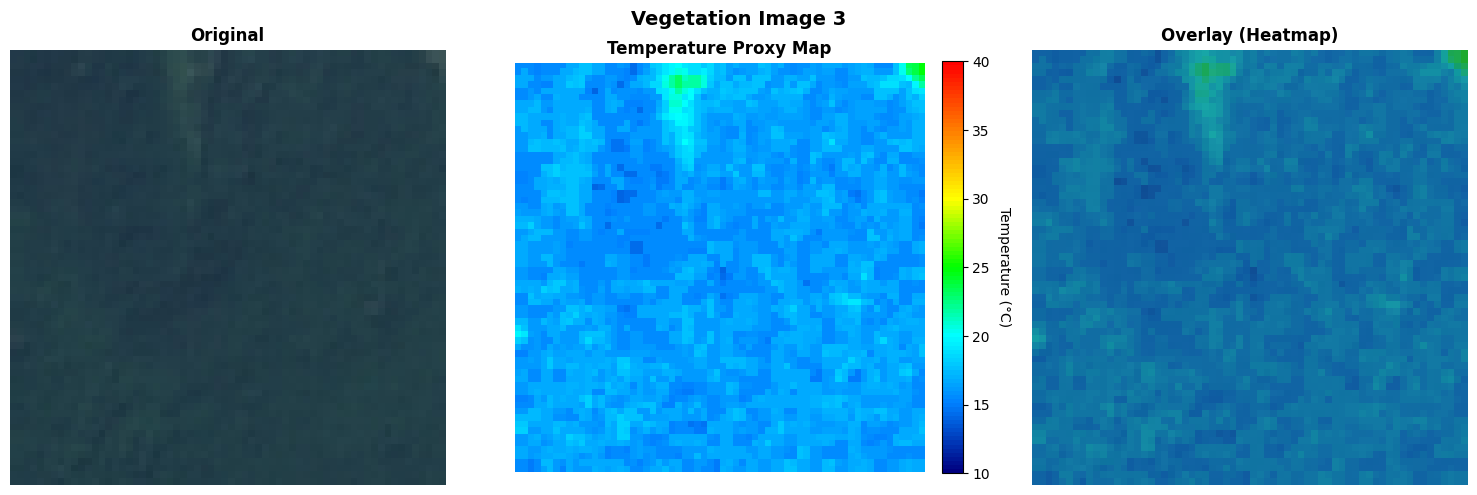

Vegetation 3: Mean temp = 16.5°C, Max = 24.8°C, Min = 14.1°C


In [9]:
# Load vegetation samples
green_samples = load_sample_images('green_area', n_samples=3)
print(f"Loaded {len(green_samples)} vegetation images")
print("\nTesting on vegetation images (expected: INTERMEDIATE temperatures)\n")

for i, img in enumerate(green_samples):
    temp_map = calculate_temperature_proxy(img)
    visualize_temperature_map(img, temp_map, title=f"Vegetation Image {i+1}")
    print(f"Vegetation {i+1}: Mean temp = {np.mean(temp_map):.1f}°C, "
          f"Max = {np.max(temp_map):.1f}°C, Min = {np.min(temp_map):.1f}°C")

### 6.4 Test on Cloudy (Expected: Cold-to-Intermediate)

Loaded 3 cloudy images

Testing on cloudy images (expected: COLD-TO-INTERMEDIATE, clouds are cold)



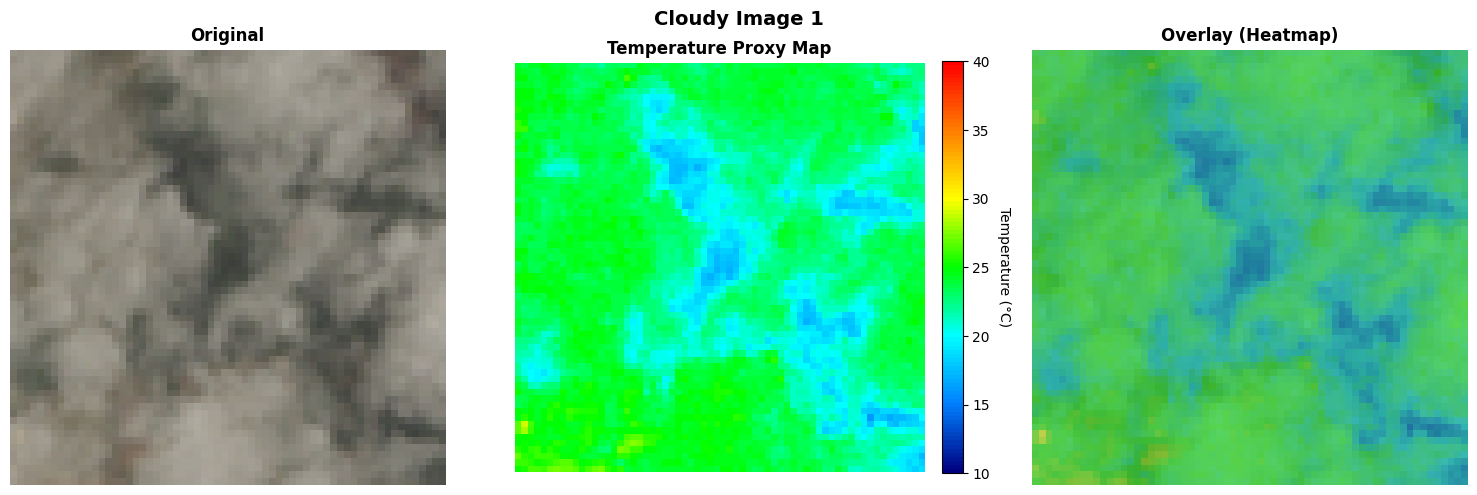

Cloudy 1: Mean temp = 22.7°C, Max = 29.0°C, Min = 16.3°C


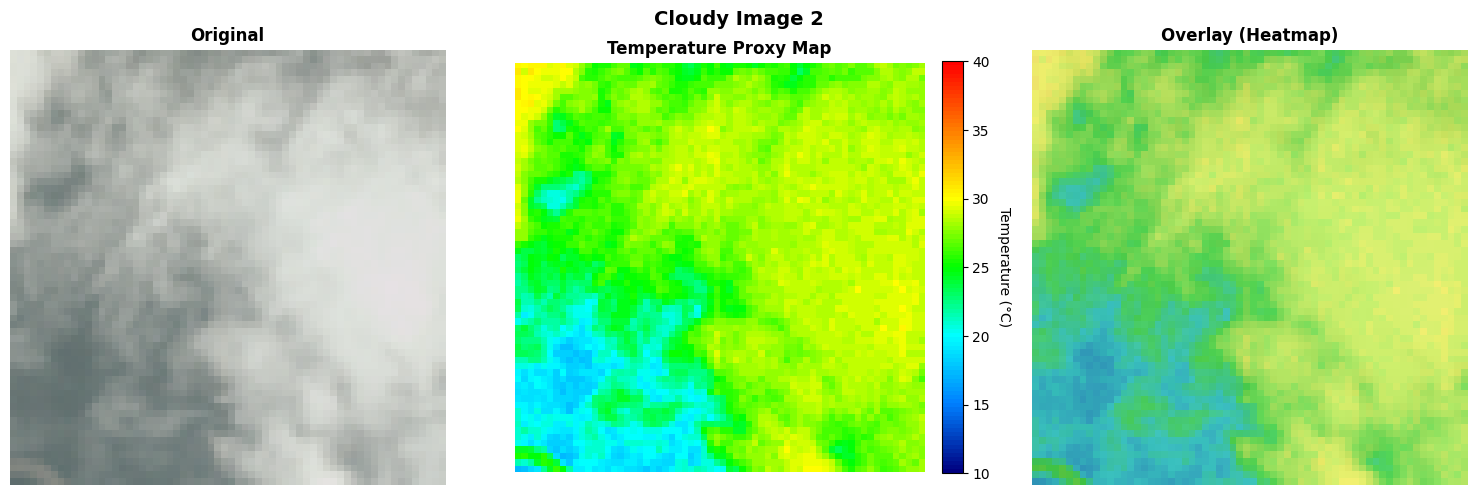

Cloudy 2: Mean temp = 26.2°C, Max = 30.8°C, Min = 17.2°C


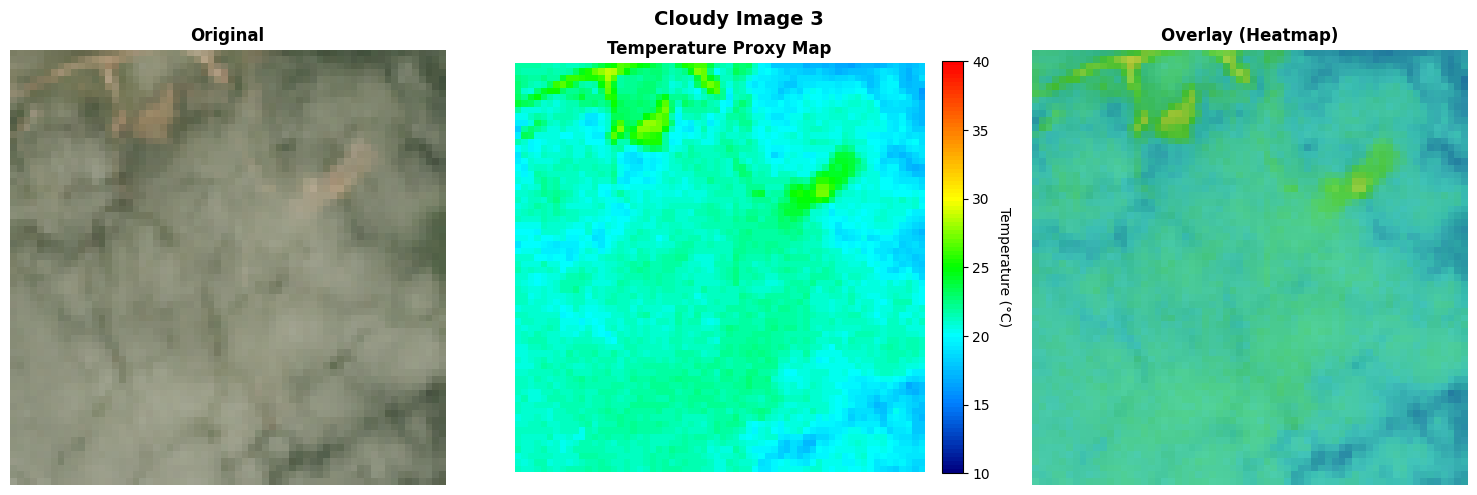

Cloudy 3: Mean temp = 21.0°C, Max = 28.7°C, Min = 16.2°C


In [10]:
# Load cloudy samples
cloudy_samples = load_sample_images('cloudy', n_samples=3)
print(f"Loaded {len(cloudy_samples)} cloudy images")
print("\nTesting on cloudy images (expected: COLD-TO-INTERMEDIATE, clouds are cold)\n")

for i, img in enumerate(cloudy_samples):
    temp_map = calculate_temperature_proxy(img)
    visualize_temperature_map(img, temp_map, title=f"Cloudy Image {i+1}")
    print(f"Cloudy {i+1}: Mean temp = {np.mean(temp_map):.1f}°C, "
          f"Max = {np.max(temp_map):.1f}°C, Min = {np.min(temp_map):.1f}°C")

## 7. Quantitative Analysis Across Categories

In [11]:
def analyze_category_temperatures(category: str, n_samples: int = 20) -> dict:
    """
    Analyze temperature proxy statistics for a category.
    
    Returns:
        dict with mean, std, min, max temperatures
    """
    images = load_sample_images(category, n_samples)
    
    mean_temps = []
    max_temps = []
    min_temps = []
    
    for img in images:
        temp_map = calculate_temperature_proxy(img)
        mean_temps.append(np.mean(temp_map))
        max_temps.append(np.max(temp_map))
        min_temps.append(np.min(temp_map))
    
    return {
        'mean_avg': np.mean(mean_temps),
        'mean_std': np.std(mean_temps),
        'max_avg': np.mean(max_temps),
        'min_avg': np.mean(min_temps)
    }


print("Analyzing temperature proxy across all categories...\n")

temp_stats = {}
for category in CATEGORIES:
    print(f"Processing {category}...")
    temp_stats[category] = analyze_category_temperatures(category, n_samples=20)

print("\n" + "="*70)
print("TEMPERATURE PROXY STATISTICS BY CATEGORY")
print("="*70)
for category in CATEGORIES:
    stats = temp_stats[category]
    print(f"\n{category.replace('_', ' ').title()}:")
    print(f"  Mean Temperature:  {stats['mean_avg']:.2f}°C ± {stats['mean_std']:.2f}°C")
    print(f"  Typical Max:       {stats['max_avg']:.2f}°C")
    print(f"  Typical Min:       {stats['min_avg']:.2f}°C")

print("\n" + "="*70)
print("Expected order (hottest to coldest): Desert > Cloudy/Vegetation > Water")
print("="*70)

Analyzing temperature proxy across all categories...

Processing cloudy...
Processing desert...
Processing green_area...
Processing water...

TEMPERATURE PROXY STATISTICS BY CATEGORY

Cloudy:
  Mean Temperature:  24.26°C ± 0.88°C
  Typical Max:       28.70°C
  Typical Min:       18.76°C

Desert:
  Mean Temperature:  24.10°C ± 1.09°C
  Typical Max:       29.48°C
  Typical Min:       19.79°C

Green Area:
  Mean Temperature:  17.54°C ± 1.06°C
  Typical Max:       25.38°C
  Typical Min:       14.15°C

Water:
  Mean Temperature:  18.81°C ± 1.74°C
  Typical Max:       24.19°C
  Typical Min:       14.52°C

Expected order (hottest to coldest): Desert > Cloudy/Vegetation > Water


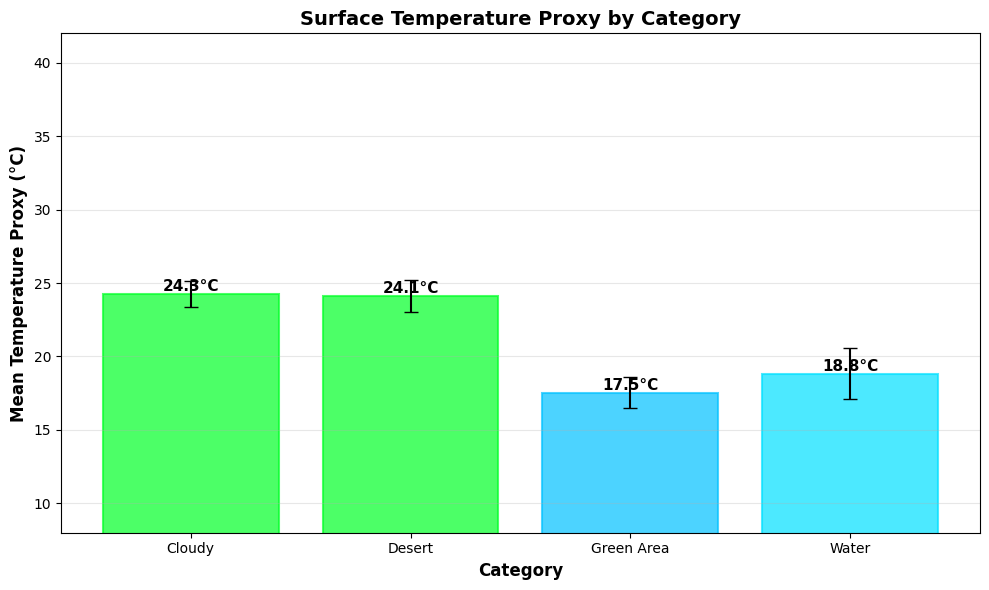

In [12]:
# Visualize temperature comparison across categories
categories_labels = [cat.replace('_', ' ').title() for cat in CATEGORIES]
mean_temps = [temp_stats[cat]['mean_avg'] for cat in CATEGORIES]
std_temps = [temp_stats[cat]['mean_std'] for cat in CATEGORIES]

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(categories_labels))
bars = ax.bar(x, mean_temps, yerr=std_temps, capsize=5, alpha=0.7,
              color=['lightblue', 'orange', 'green', 'cyan'],
              edgecolor='black', linewidth=1.5)

# Color bars by temperature (visual cue)
cmap = create_custom_temp_colormap()
for i, (bar, temp) in enumerate(zip(bars, mean_temps)):
    temp_norm = (temp - TEMP_MIN) / (TEMP_MAX - TEMP_MIN)
    bar.set_color(cmap(temp_norm))

ax.set_xlabel('Category', fontsize=12, fontweight='bold')
ax.set_ylabel('Mean Temperature Proxy (°C)', fontsize=12, fontweight='bold')
ax.set_title('Surface Temperature Proxy by Category', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories_labels)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([TEMP_MIN - 2, TEMP_MAX + 2])

# Add value labels
for i, (bar, temp) in enumerate(zip(bars, mean_temps)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{temp:.1f}°C',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## 8. Side-by-Side Category Comparison

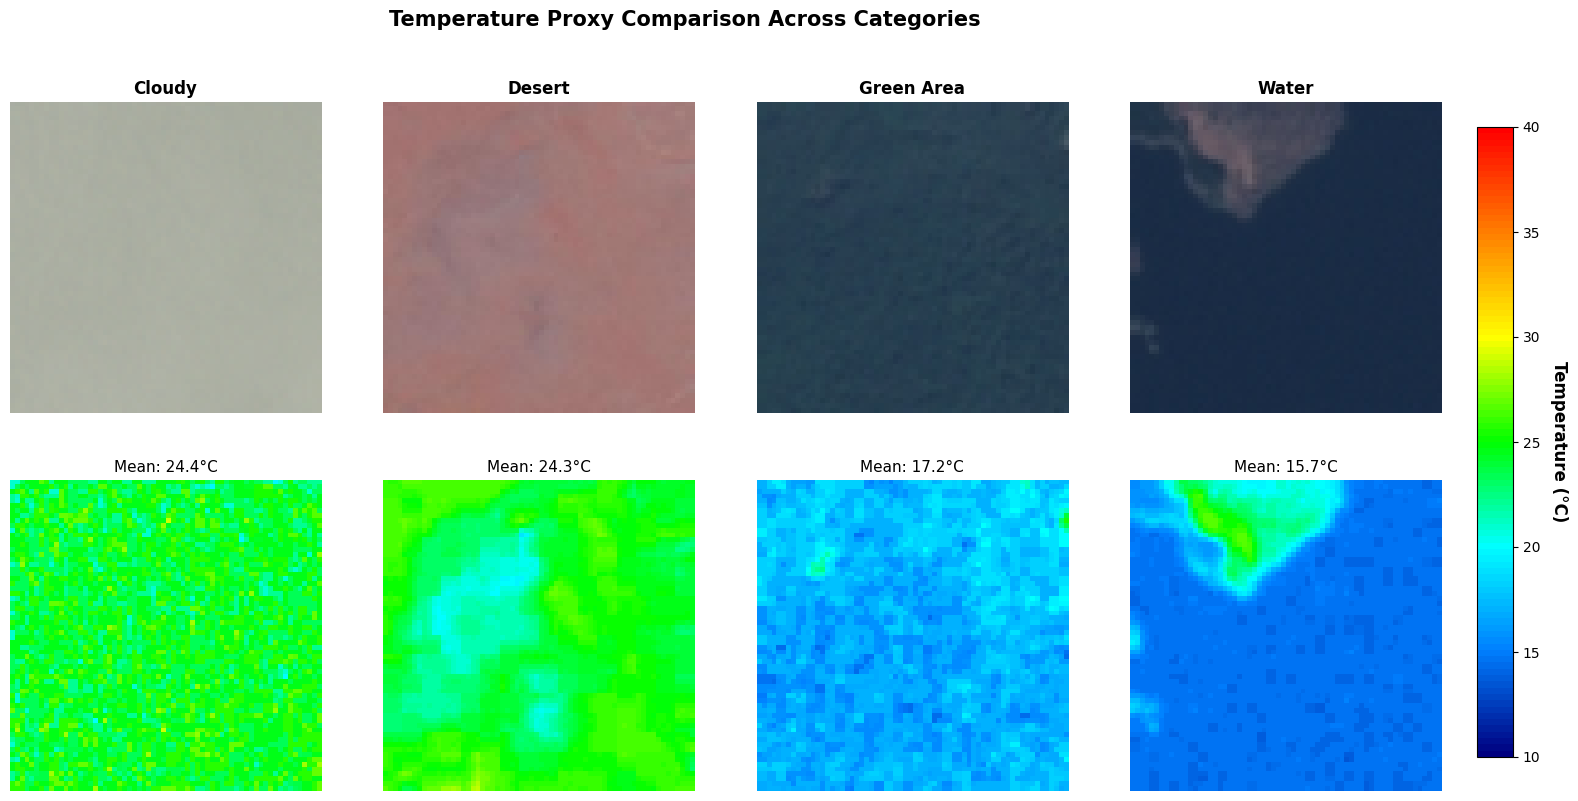

In [13]:
# Load one sample from each category and compare
sample_images = {}
for category in CATEGORIES:
    sample_images[category] = load_sample_images(category, n_samples=1)[0]

# Create comparison grid
fig, axes = plt.subplots(2, 4, figsize=(18, 9))

cmap = create_custom_temp_colormap()

for idx, category in enumerate(CATEGORIES):
    img = sample_images[category]
    temp_map = calculate_temperature_proxy(img)
    
    # Original image
    axes[0, idx].imshow(img)
    axes[0, idx].set_title(category.replace('_', ' ').title(), 
                          fontsize=12, fontweight='bold')
    axes[0, idx].axis('off')
    
    # Temperature map
    im = axes[1, idx].imshow(temp_map, cmap=cmap, vmin=TEMP_MIN, vmax=TEMP_MAX)
    axes[1, idx].set_title(f'Mean: {np.mean(temp_map):.1f}°C', 
                          fontsize=11)
    axes[1, idx].axis('off')

# Add colorbar
fig.subplots_adjust(right=0.92)
cbar_ax = fig.add_axes([0.94, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Temperature (°C)', rotation=270, labelpad=20, fontsize=12, fontweight='bold')

plt.suptitle('Temperature Proxy Comparison Across Categories', 
             fontsize=15, fontweight='bold', y=0.98)
plt.show()

## 9. Validation: Does the Proxy Make Sense?

In [14]:
print("\n" + "="*70)
print("TEMPERATURE PROXY VALIDATION")
print("="*70)

# Check if ordering makes physical sense
ordered_categories = sorted(CATEGORIES, 
                           key=lambda x: temp_stats[x]['mean_avg'], 
                           reverse=True)

print("\nCategories ordered by temperature proxy (hottest to coldest):")
for i, category in enumerate(ordered_categories):
    temp = temp_stats[category]['mean_avg']
    print(f"  {i+1}. {category.replace('_', ' ').title()}: {temp:.2f}°C")

print("\nPhysical interpretation:")
if ordered_categories[0] == 'desert':
    print("  ✓ Desert is hottest (correct - exposed sand/rock absorbs heat)")
else:
    print(f"  ⚠ {ordered_categories[0]} is hottest (expected: desert)")

if ordered_categories[-1] == 'water':
    print("  ✓ Water is coldest (correct - high heat capacity, evaporation)")
else:
    print(f"  ⚠ {ordered_categories[-1]} is coldest (expected: water)")

# Check temperature spread
temp_range = temp_stats[ordered_categories[0]]['mean_avg'] - temp_stats[ordered_categories[-1]]['mean_avg']
print(f"\nTemperature spread: {temp_range:.2f}°C")
if temp_range > 5:
    print("  ✓ Good separation between categories (>5°C difference)")
else:
    print("  ⚠ Low separation - consider adjusting weights")

print("\n" + "="*70)
print("NOTE: These are VISUAL PROXIES, not real temperatures!")
print("      Real surface temperature requires thermal/infrared bands.")
print("="*70)


TEMPERATURE PROXY VALIDATION

Categories ordered by temperature proxy (hottest to coldest):
  1. Cloudy: 24.26°C
  2. Desert: 24.10°C
  3. Water: 18.81°C
  4. Green Area: 17.54°C

Physical interpretation:
  ⚠ cloudy is hottest (expected: desert)
  ⚠ green_area is coldest (expected: water)

Temperature spread: 6.72°C
  ✓ Good separation between categories (>5°C difference)

NOTE: These are VISUAL PROXIES, not real temperatures!
      Real surface temperature requires thermal/infrared bands.


## 10. Summary

In [15]:
print("\n" + "="*70)
print("TEMPERATURE PROXY - SUMMARY")
print("="*70)

print("\nApproach:")
print("  Temperature Proxy = weighted combination of:")
print(f"    - Red Ratio (R/(R+G+B)):      {WEIGHTS['red_ratio']*100:.0f}%")
print(f"    - R-B Difference (warmth):    {WEIGHTS['rb_diff']*100:.0f}%")
print(f"    - Brightness (0-255):         {WEIGHTS['brightness']*100:.0f}%")

print(f"\nTemperature scale: {TEMP_MIN}°C - {TEMP_MAX}°C (arbitrary/visual)")

print("\nVisualization:")
print("  - Custom colormap: blue (cold) → green → yellow → red (hot)")
print("  - Heatmap overlay with transparency")
print("  - Side-by-side comparison")

print("\nResults by Category:")
for category in ordered_categories:
    stats = temp_stats[category]
    print(f"  - {category.replace('_', ' ').title()}: {stats['mean_avg']:.1f}°C ± {stats['mean_std']:.1f}°C")

print("\nKey Insights:")
print(f"  - Hottest: {ordered_categories[0].replace('_', ' ').title()} "
      f"({temp_stats[ordered_categories[0]]['mean_avg']:.1f}°C)")
print(f"  - Coldest: {ordered_categories[-1].replace('_', ' ').title()} "
      f"({temp_stats[ordered_categories[-1]]['mean_avg']:.1f}°C)")
print(f"  - Temperature range: {temp_range:.1f}°C")

print("\nLimitations:")
print("  ⚠ This is a VISUAL PROXY based on RGB colors only")
print("  ⚠ NOT real surface temperature (would need thermal/IR bands)")
print("  ⚠ Brightness can be affected by time of day, shadows, clouds")
print("  ⚠ Best used for relative comparison, not absolute values")

print("\n" + "="*70)
print("✓ Temperature proxy estimation completed")
print("  Next step: ML Classification (06_ml_classification.ipynb)")
print("="*70)


TEMPERATURE PROXY - SUMMARY

Approach:
  Temperature Proxy = weighted combination of:
    - Red Ratio (R/(R+G+B)):      40%
    - R-B Difference (warmth):    30%
    - Brightness (0-255):         30%

Temperature scale: 10°C - 40°C (arbitrary/visual)

Visualization:
  - Custom colormap: blue (cold) → green → yellow → red (hot)
  - Heatmap overlay with transparency
  - Side-by-side comparison

Results by Category:
  - Cloudy: 24.3°C ± 0.9°C
  - Desert: 24.1°C ± 1.1°C
  - Water: 18.8°C ± 1.7°C
  - Green Area: 17.5°C ± 1.1°C

Key Insights:
  - Hottest: Cloudy (24.3°C)
  - Coldest: Green Area (17.5°C)
  - Temperature range: 6.7°C

Limitations:
  ⚠ This is a VISUAL PROXY based on RGB colors only
  ⚠ NOT real surface temperature (would need thermal/IR bands)
  ⚠ Brightness can be affected by time of day, shadows, clouds
  ⚠ Best used for relative comparison, not absolute values

✓ Temperature proxy estimation completed
  Next step: ML Classification (06_ml_classification.ipynb)
